In [1]:
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, librosa, IPython.display
%matplotlib inline

In [3]:
files_path = 'MIR-1K_for_MIREX/Wavfile/'

In [8]:
x,fs = librosa.load(files_path+'yifen_5_05.wav')
IPython.display.Audio(x, rate=fs)

In [9]:
X = librosa.stft(x)
H, P = librosa.decompose.hpss(X)

In [10]:
h = librosa.istft(H)

In [11]:
IPython.display.Audio(h, rate=fs)

In [15]:
import librosa.display

In [39]:
X = np.abs(librosa.stft(x))
freqs = librosa.core.fft_frequencies(fs)
harms=[1,2,3,4]
weights = [1.0, 0.5, 0.33, 0.25]
X_sal = librosa.salience(X,freqs,harms,weights,fill_value=0)

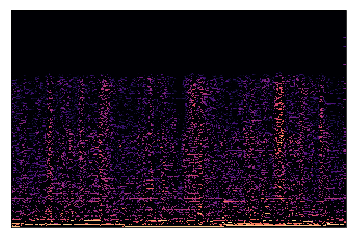

In [41]:
librosa.display.specshow(librosa.amplitude_to_db(X_sal,ref=np.max))

In [35]:
np.abs(X[:,:2000]).shape

(513, 322)

In [7]:
#librosa.output.write_wav('train03_h.wav', h, fs)

# Pitch Detection using YIN algorithm

In [1]:
import os.path
from numpy import array, ma
import numpy as np
import numpy,scipy, sklearn
import librosa
from aubio import source,pitch
# import IPython.display #import when running in Jupyter notebook
import matplotlib.pyplot as plt
%matplotlib inline

def array_from_text_file(filename, dtype = 'float'):
    return array([line.split() for line in open(filename).readlines()],
        dtype = dtype)


def pitch_detection(filename,sr,ground_truth,win_s,hop_s,downsample,tolerance,pitch_method,draw=True):
    # global pitch,source
    samplerate = sr
    s = source(filename, samplerate, hop_s)
    samplerate = s.samplerate

    pitch_o = pitch(pitch_method, win_s, hop_s, samplerate)
    # pitch_o.set_unit("midi") # default is HZ
    pitch_o.set_tolerance(tolerance)

    pitches = []
    confidences = []

    # total number of frames read
    total_frames = 0
    while True:
        samples, read = s()
        pitch_sample = pitch_o(samples)[0]
        confidence = pitch_o.get_confidence()

        pitches += [pitch_sample]
        confidences += [confidence]
        total_frames += read
        if read < hop_s: break

    # detect pitches
    skip = 1

    pitches = array(pitches[skip:])
    confidences = array(confidences[skip:])
    times = [t * hop_s for t in range(len(pitches))]

    if os.path.isfile(ground_truth):
        ground_truth = array_from_text_file(ground_truth)
        true_freqs = ground_truth[:,1]
        true_freqs = ma.masked_where(true_freqs < 2, true_freqs)
        true_times = ground_truth[:,0]

    cleaned_pitches = pitches
    cleaned_pitches = ma.masked_where(confidences < tolerance, cleaned_pitches)
    actual_times = [t/float(samplerate) for t in times]
    cleaned_pitches = ma.masked_where(cleaned_pitches > 800, cleaned_pitches)
    cleaned_pitches = ma.masked_where(cleaned_pitches < 50, cleaned_pitches)
    
    if draw:
        plt.plot(actual_times, cleaned_pitches, 'g')
        plt.plot(true_times, true_freqs, 'r')
        plt.show()
    return (actual_times,cleaned_pitches),(true_times,true_freqs)

# def save_harmonic_file(filename):
#     x,fs = librosa.load(filename)
#     X = librosa.stft(x)
#     H, P = librosa.decompose.hpss(X)
#     h = librosa.istft(H)
    
#     output = filename.split('.')[0]+'_h.wav'
#     if not os.path.isfile(output):
#         print('Saving output file:',output)
#         librosa.output.write_wav(output, h, fs)
#     return output,fs


In [2]:
def filter_freq(predict_time,true_time_freq):
    result = [9999] if predict_time[0] == 0 else []
    filtered = filter(lambda x:x[0] in predict_time,true_time_freq)
    result.extend(map(lambda x:x[1],filtered))
    return np.array(result)
def gross_error(pitch_detection_result):
    predict_time,predict_freq = pitch_detection_result[0]
    predict_time = np.round(np.array(predict_time),2)
    predict_freq = np.array(predict_freq)
    true_time,true_freq = pitch_detection_result[1]
    true_freq.mask = ma.nomask
    true_freq_filtered = true_freq[:]
    predict_freq_filtered = [predict_freq[0]]
    predict_freq_filtered.extend([predict_freq[i] for i in range(1,len(predict_time)) if predict_time[i]!= predict_time[i-1] and predict_time[i]<=true_time[-1]])
    
    true_time_freq = zip(true_time,true_freq)
    true_freq_filtered = filter_freq(predict_time,true_time_freq)
    
    return sum((abs(predict_freq_filtered-true_freq_filtered)>true_freq_filtered*0.2))/(len(predict_freq_filtered)+0.0)


In [3]:
def write_output(output_path,filenames,gross_errors):
    output_file = os.path.join(output_path,'output.txt')
    if not os.path.isfile(output_file):
        print 'writing output file',output_file
        with open(output_file, 'a') as f:
            for i in range(len(filenames)):
                name,error = filenames[i],gross_errors[i]
                f.write(str(name)+'\t'+str(error)+'\n')
        f.close()
    else:
        print 'output already exist. no need to write'

In [8]:
# import os
# import numpy as np
wav_path = "MIR-1K_for_MIREX/results/"
truth_path = 'MIR-1K_for_MIREX/PitchLabel/'

sr = 44100
downsample = 1
win_s = 2048 // downsample # fft size
hop_s = 1024  // downsample # hop size
tolerance = 0.85
pitch_method='yin'

import warnings
warnings.filterwarnings('ignore')

filenames,gross_errors = [],[]
count = 0
for file in os.listdir(wav_path): 
    if file.endswith(".wav"): # find all files ending in wav
        count += 1
        if count % 500 == 0:
            print count
        file_path = os.path.join(wav_path,file)
        file_head = '_'.join(file.split('_')[:3])
        
        truth_file = os.path.join(truth_path,file_head+'.pv') # organize ground truth file names
        
        result = pitch_detection(file_path,sr,truth_file,win_s,hop_s,downsample,tolerance,pitch_method,draw=False)
        error = gross_error(result)
        filenames.append(file)
        gross_errors.append(error)

500
1000
1500
2000


In [15]:
gross_errors

[0.21562500000000001, 0.62812500000000004]

In [9]:
def write_output2(output_path,filenames,gross_errors,types):
    output_file = os.path.join(output_path,'output.txt')
    if not os.path.isfile(output_file):
        print 'writing output file',output_file
        with open(output_file, 'a') as f:
            for i in range(len(filenames)):
                name,error,mask_type = filenames[i],gross_errors[i],types[i]
                f.write(str(name)+'\t'+str(error)+'\t'+mask_type+'\n')
        f.close()
    else:
        print 'output already exist. no need to write'

In [10]:
types = map(lambda x:x.split('_')[-2],filenames)
write_output2("MIR-1K_for_MIREX",filenames,gross_errors,types)

writing output file MIR-1K_for_MIREX/output.txt


In [11]:
import pandas as pd
data = pd.read_table('MIR-1K_for_MIREX/output_source_separation.txt',names=['filename','gross_error','mask_type'])
data.head(2)

,filename,gross_error,mask_type
0,abjones_5_08_iter400_bmask_signal.wav,0.572785,bmask
1,abjones_5_08_iter400_nomask_signal.wav,0.601266,nomask


In [12]:
data.groupby(['mask_type']).gross_error.mean()

mask_type
bmask       0.429836
nomask      0.467392
softmask    0.467392
Name: gross_error, dtype: float64

In [14]:
data.gross_error.mean()

0.45487350268205684

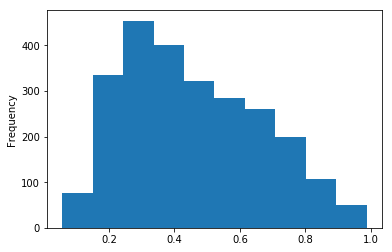

In [13]:
data.gross_error.plot(kind='hist')

MIR-1K_for_MIREX/results/bug_3_09_iter400_bmask_signal.wav


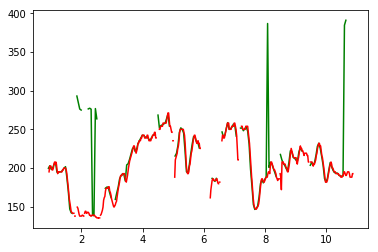

MIR-1K_for_MIREX/results/heycat_3_08_iter400_bmask_signal.wav


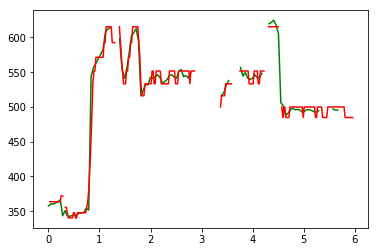

MIR-1K_for_MIREX/results/Kenshin_2_05_iter400_bmask_signal.wav


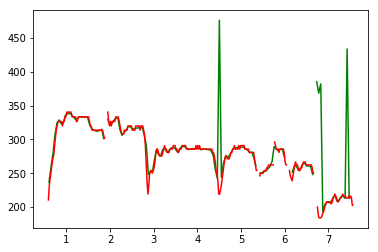

MIR-1K_for_MIREX/results/Kenshin_2_10_iter400_bmask_signal.wav


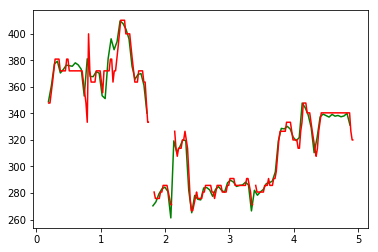

MIR-1K_for_MIREX/results/yifen_2_08_iter400_bmask_signal.wav


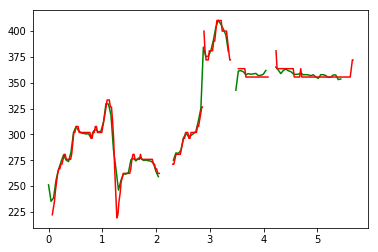

In [19]:
good_results = ['bug_3_09_iter400_bmask_signal.wav','heycat_3_08_iter400_bmask_signal.wav',
                'Kenshin_2_05_iter400_bmask_signal.wav','Kenshin_2_10_iter400_bmask_signal.wav',
                'yifen_2_08_iter400_bmask_signal.wav']
ground_truth_files = ['bug_3_09.pv','heycat_3_08.pv','Kenshin_2_05.pv','Kenshin_2_10.pv','yifen_2_08.pv']
wav_path = "MIR-1K_for_MIREX/results/"
truth_path = 'MIR-1K_for_MIREX/PitchLabel/'
for i in range(5):
    filename = good_results[i]
    filename = os.path.join(wav_path,filename)
    ground_truth_file = ground_truth_files[i]
    ground_truth_file = os.path.join(truth_path,ground_truth_file)
    _,sr = librosa.load(filename)
    #filename,sr = save_harmonic_file(filename) # result is worse
    print filename
    pitch_detection(filename,sr,ground_truth_file,win_s,hop_s,downsample,tolerance,pitch_method)

## YIN algorithm error baseline

In [4]:
# import os
# import numpy as np
wav_path = "MIR-1K_for_MIREX/Wavfile/"
truth_path = 'MIR-1K_for_MIREX/PitchLabel/'

sr = 44100
downsample = 1
win_s = 2048 // downsample # fft size
hop_s = 1024  // downsample # hop size
tolerance = 0.85
pitch_method='yin'

import warnings
warnings.filterwarnings('ignore')

filenames,gross_errors = [],[]
count = 0
for file in os.listdir(wav_path): 
    if file.endswith(".wav"): # find all files ending in wav
        count += 1
        if count % 500 == 0:
            print count
        file_path = os.path.join(wav_path,file)
        file_head = file.split('.')[0]
        
        truth_file = os.path.join(truth_path,file_head+'.pv') # organize ground truth file names
        
        result = pitch_detection(file_path,sr,truth_file,win_s,hop_s,downsample,tolerance,pitch_method,draw=False)
        error = gross_error(result)
        filenames.append(file)
        gross_errors.append(error)

500
1000


In [5]:
write_output("MIR-1K_for_MIREX",filenames,gross_errors)

writing output file MIR-1K_for_MIREX/output.txt


In [8]:
import pandas as pd
data = pd.read_table("MIR-1K_for_MIREX/output.txt",names=['filename','gross_error'])
data.head(2)

,filename,gross_error
0,abjones_1_01.wav,0.547094
1,abjones_1_02.wav,0.608108


In [9]:
data.gross_error.mean()

0.57490025922575505

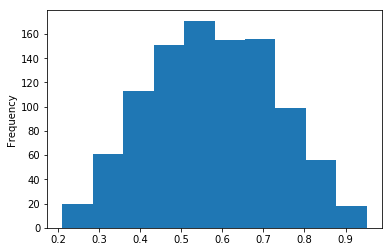

In [10]:
data.gross_error.plot(kind='hist')

## Best algorithm hidden

In [15]:
data = pd.read_table('MIR-1K_for_MIREX/output_melodia.txt',names=['filename','gross_error','mask_type'])
data.head(2)

,filename,gross_error,mask_type
0,abjones_5_08_iter400_bmask_signal.wav,0.020464,NaN
1,abjones_5_08_iter400_nomask_signal.wav,0.212824,NaN


In [16]:
data.gross_error.mean()

0.091553745154517627

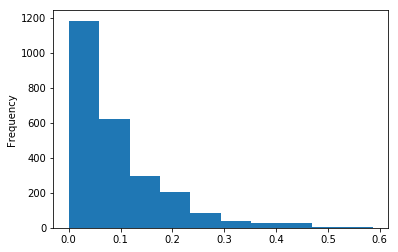

In [17]:
data.gross_error.plot(kind='hist')

*****
# Old version of pitch detection codes

In [7]:
files_path = 'MIR-1K_for_MIREX/Wavfile/'
truth_path = 'MIR-1K_for_MIREX/PitchLabel/'

filenames = [files_path+'yifen_1_'+str((i+1)/10)*(1-(i+1)/10)+str(i+1)+'.wav' for i in range(12)]
ground_truth_files = [truth_path+'yifen_1_'+str((i+1)/10)*(1-(i+1)/10)+str(i+1)+'.pv' for i in range(12)]

downsample = 1
win_s = 2048 // downsample # fft size
hop_s = 1024  // downsample # hop size
tolerance = 0.85
pitch_method='yin'

In [8]:
import warnings
warnings.filterwarnings('ignore')


('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_01.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_01.wav from 16000Hz to 22050Hz


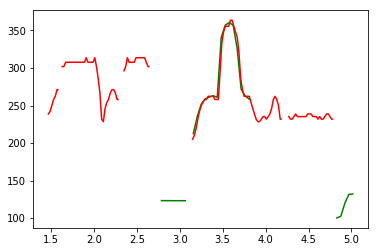

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_02.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_02.wav from 16000Hz to 22050Hz


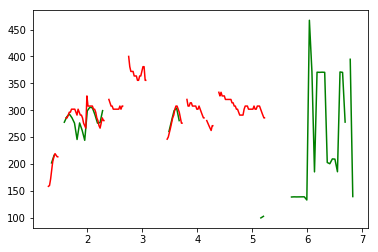

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_03.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_03.wav from 16000Hz to 22050Hz


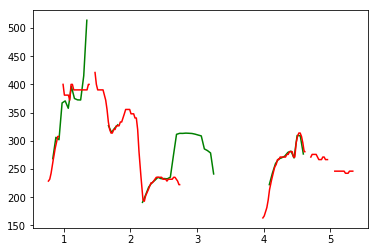

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_04.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_04.wav from 16000Hz to 22050Hz


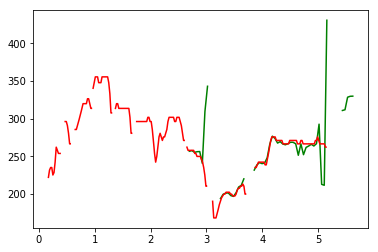

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_05.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_05.wav from 16000Hz to 22050Hz


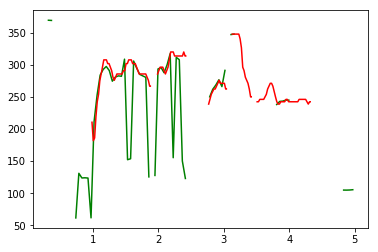

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_06.wav from 16000Hz to 22050Hz


('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_06.pv')


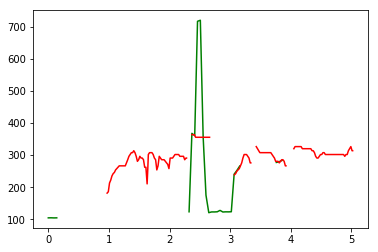

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_07.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_07.wav from 16000Hz to 22050Hz


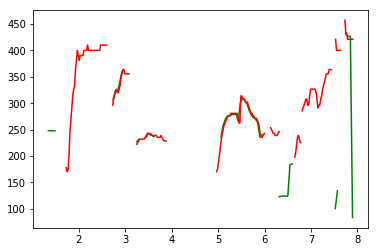

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_08.wav from 16000Hz to 22050Hz


('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_08.pv')


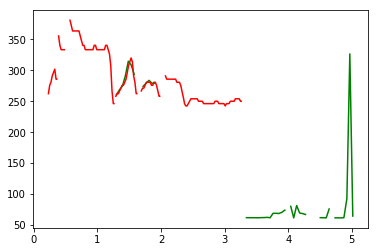

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_09.wav from 16000Hz to 22050Hz


('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_09.pv')


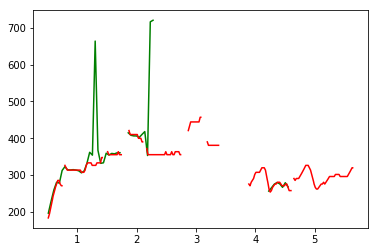

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_10.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_10.wav from 16000Hz to 22050Hz


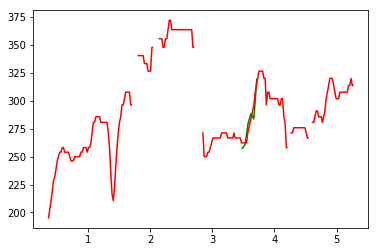

('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_11.pv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_11.wav from 16000Hz to 22050Hz


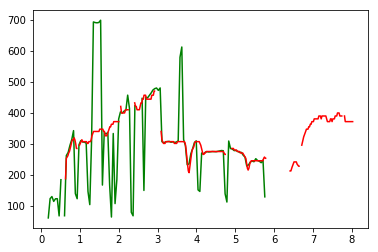

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling MIR-1K_for_MIREX/Wavfile/yifen_1_12.wav from 16000Hz to 22050Hz


('ground truth file dir:', 'MIR-1K_for_MIREX/PitchLabel/yifen_1_12.pv')


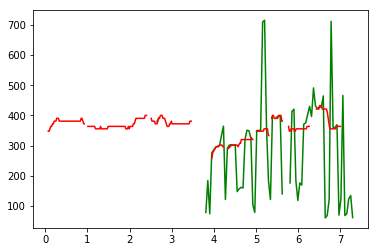

In [8]:
for i in range(12):
    filename = filenames[i]
    ground_truth_file = ground_truth_files[i]
    _,sr = librosa.load(filename)
    #filename,sr = save_harmonic_file(filename) # result is worse
    pitch_detection(filename,sr,ground_truth_file,win_s,hop_s,downsample,tolerance,pitch_method)

('Saving output file:', 'train01_h.wav')
('ground truth file dir:', 'train01REF.txt')


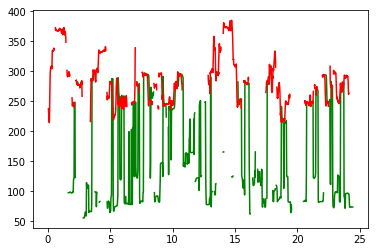

('Saving output file:', 'train02_h.wav')
('ground truth file dir:', 'train02REF.txt')


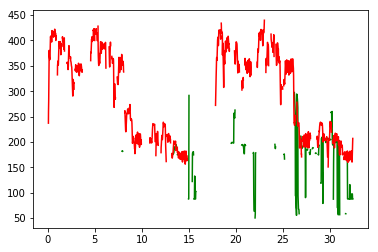

('ground truth file dir:', 'train03REF.txt')


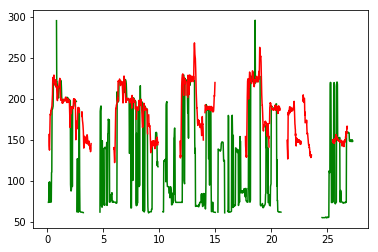

('Saving output file:', 'train04_h.wav')
('ground truth file dir:', 'train04REF.txt')


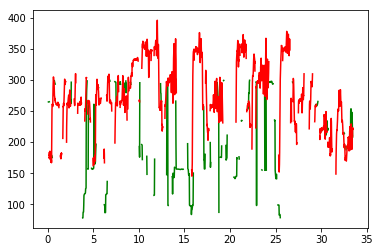

('Saving output file:', 'train05_h.wav')
('ground truth file dir:', 'train05REF.txt')


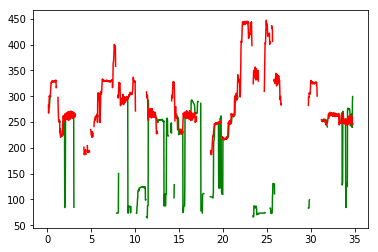

('Saving output file:', 'train06_h.wav')
('ground truth file dir:', 'train06REF.txt')


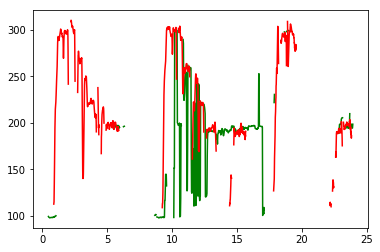

('Saving output file:', 'train07_h.wav')
('ground truth file dir:', 'train07REF.txt')


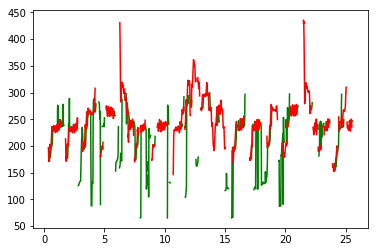

('Saving output file:', 'train08_h.wav')
('ground truth file dir:', 'train08REF.txt')


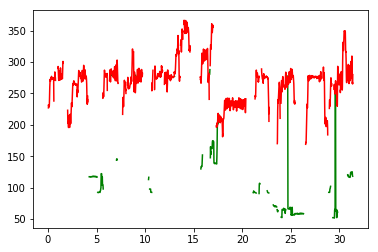

('Saving output file:', 'train09_h.wav')
('ground truth file dir:', 'train09REF.txt')


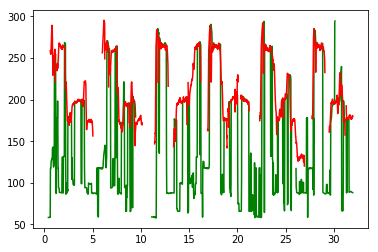

('Saving output file:', 'train10_h.wav')
('ground truth file dir:', 'train10REF.txt')


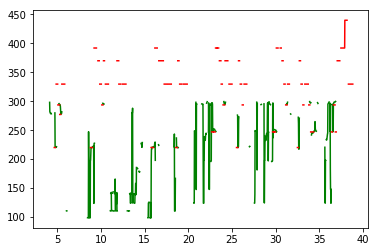

('Saving output file:', 'train11_h.wav')
('ground truth file dir:', 'train11REF.txt')


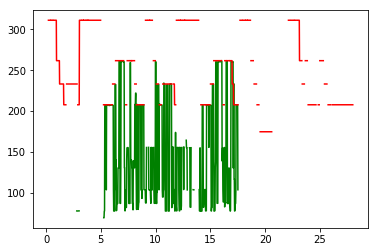

('Saving output file:', 'train12_h.wav')
('ground truth file dir:', 'train12REF.txt')


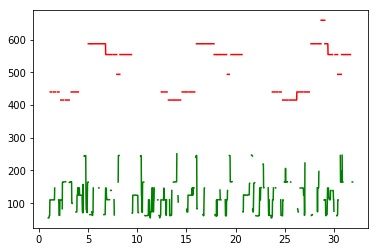

('Saving output file:', 'train13MIDI_h.wav')
('ground truth file dir:', 'train13REF.txt')


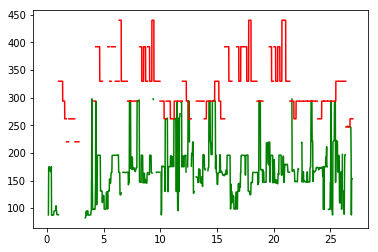

In [22]:
# filenames = ['train'+str((i+1)/10)*(1-(i+1)/10)+str(i+1)+'.wav' for i in range(12)]
# filenames += ['train13MIDI.wav'];filenames
# ground_truth_files = ['train'+str((i+1)/10)*(1-(i+1)/10)+str(i+1)+'REF.txt' for i in range(13)]
# ground_truth_files
# for i in range(13):
#     filename = filenames[i]
#     ground_truth_file = ground_truth_files[i]
#     filename,sr = save_harmonic_file(filename)
#     pitch_detection(filename,sr,ground_truth_file,win_s,hop_s,downsample,tolerance,pitch_method)

22050